# About this Notebook

The purpose of this notebook is to study a convolutional network solution. The MLP performs well when the validation/test is on the same flight as the training, however it does not generalize well to other flights. We will therefore try to use a new architecture able to detect more complex pattern in the data : a convolutional network. See previous notebook for more details

Multivariate Multiple input time series data

# Table of Contents

# Import packages

In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import magnav
from tabulate import tabulate
from tqdm.notebook import tqdm_notebook

In [3]:
torch.manual_seed(27) # For reproducibility

In [4]:
# device = magnav.get_device()
device = torch.device('cuda:0')

# 1 - What is a Convolutional Neural Network

# 2 - Import of Data

In [5]:
df2 = pd.read_hdf('../data/interim/Chall_dataset.h5', key=f'Flt1002')
df3 = pd.read_hdf('../data/interim/Chall_dataset.h5', key=f'Flt1003')
df4 = pd.read_hdf('../data/interim/Chall_dataset.h5', key=f'Flt1004')

In [6]:
df2.head()

,TL_comp_mag3_cl,TL_comp_mag5_cl,V_BAT1,V_BAT2,INS_ACC_X,INS_ACC_Y,INS_ACC_Z,CUR_IHTR,PITCH,ROLL,AZIMUTH,LINE,IGRFMAG1
Time [s],,,,,,,,,,,,,
45100.0,-1026.777805,-44.982774,25.827,2.015,-0.109544,-0.389939,9.353474,1.734,9.19,0.19,204.01,1002.01,-297.343
45100.1,-1023.030351,-40.600326,25.826,2.014,-0.157305,-0.441169,9.317263,1.759,9.08,-0.03,203.95,1002.01,-296.223
45100.2,-1021.286230,-34.817623,25.824,2.013,-0.179486,-0.462637,9.348927,1.783,8.96,-0.22,203.91,1002.01,-295.079
45100.3,-1023.965085,-29.347438,25.820,2.010,-0.208515,-0.496153,9.333830,1.796,8.85,-0.39,203.90,1002.01,-293.939
45100.4,-1030.701663,-25.421394,25.815,2.007,-0.252133,-0.507891,9.261835,1.788,8.73,-0.55,203.91,1002.01,-292.821


# 3 - Normalization

In [7]:
df2.describe()

scaling_range = [-1,1]
MinMaxScaler_2 = MinMaxScaler(scaling_range)
MinMaxScaler_3 = MinMaxScaler(scaling_range)
MinMaxScaler_4 = MinMaxScaler(scaling_range)


df2_scaled = pd.DataFrame()
df3_scaled = pd.DataFrame()
df4_scaled = pd.DataFrame()


df2_scaled[df2.drop(columns=['LINE','IGRFMAG1']).columns] = MinMaxScaler_2.fit_transform(df2.drop(columns=['LINE','IGRFMAG1']))
df3_scaled[df3.drop(columns=['LINE','IGRFMAG1']).columns] = MinMaxScaler_3.fit_transform(df3.drop(columns=['LINE','IGRFMAG1']))
df4_scaled[df4.drop(columns=['LINE','IGRFMAG1']).columns] = MinMaxScaler_4.fit_transform(df4.drop(columns=['LINE','IGRFMAG1']))

df2_scaled.index = df2.index
df3_scaled.index = df3.index
df4_scaled.index = df4.index

df2_scaled[['LINE','IGRFMAG1']] = df2[['LINE','IGRFMAG1']]
df3_scaled[['LINE','IGRFMAG1']] = df3[['LINE','IGRFMAG1']]
df4_scaled[['LINE','IGRFMAG1']] = df4[['LINE','IGRFMAG1']]

df2_scaled.describe()

,TL_comp_mag3_cl,TL_comp_mag5_cl,V_BAT1,V_BAT2,INS_ACC_X,INS_ACC_Y,INS_ACC_Z,CUR_IHTR,PITCH,ROLL,AZIMUTH,LINE,IGRFMAG1
count,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000
mean,0.120479,-0.499555,-0.643363,-0.078342,-0.124208,-0.031765,0.058171,-0.026525,0.202881,-0.090270,0.105508,1152.355312,15.822918
std,0.060556,0.148419,0.223182,0.484986,0.168563,0.163822,0.109107,0.352792,0.232093,0.257489,0.537493,603.633030,263.641503
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,158.000000,-868.652000
25%,0.092208,-0.566069,-0.749049,-0.471795,-0.174118,-0.076751,0.013592,-0.260143,0.078834,-0.167997,-0.246764,1002.030000,-106.787250
50%,0.119767,-0.498298,-0.673004,-0.298462,-0.122392,-0.031005,0.058330,-0.072517,0.188985,-0.101912,0.016722,1002.150000,24.219500
75%,0.149140,-0.444462,-0.596958,0.360000,-0.071264,0.014450,0.103938,0.166514,0.307775,-0.032857,0.608167,1002.200000,120.868500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3086.000000,2699.331000


# 4 - Input Sequence

In [8]:
def trim_data(data,seq_length):
    # Remove excessive data that cannot be in a full sequence
    if (len(data)%seq_length) != 0:
        data = data[:-(len(data)%seq_length)]
    else:
        pass
        
    return data

In [9]:
class MagNavDataset(Dataset):
    # split can be 'Train', 'Val', 'Test'
    def __init__(self, df, seq_length, split):
        
        self.seq_length = seq_length
        
        # Get list of features
        self.features   = df.drop(columns=['LINE','IGRFMAG1']).columns.to_list()
        
        if split == 'train':
            
            sections = np.delete(np.concatenate([df2_scaled.LINE.unique(),df3_scaled.LINE.unique()]),20)
            mask_train = pd.Series(dtype=bool)
            for line in sections:
                mask  = (df.LINE == line)
                mask_train = mask|mask_train
            
            X_train    = df.loc[mask_train,self.features]
            y_train    = df.loc[mask_train,'IGRFMAG1']
            
            self.X = trim_data(torch.tensor(X_train.to_numpy(),dtype=torch.float32),seq_length)
            self.y = trim_data(torch.tensor(np.reshape(y_train.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)
            
        elif split == 'val':
            
            mask_val   = (df.LINE == 1002.14)
            
            X_val      = df.loc[mask_val,self.features]
            y_val      = df.loc[mask_val,'IGRFMAG1']
            
            self.X = trim_data(torch.tensor(X_val.to_numpy(),dtype=torch.float32),seq_length)
            self.y = trim_data(torch.tensor(np.reshape(y_val.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)
            
        elif split == 'test':
            
            mask_test = pd.Series(dtype=bool)
            for line in df4_scaled.LINE.unique():
                mask  = (df.LINE == line)
                mask_test = mask|mask_test
            
            X_test     = df.loc[mask_test,self.features]
            y_test     = df.loc[mask_test,'IGRFMAG1']
            
            self.X = trim_data(torch.tensor(X_test.to_numpy(),dtype=torch.float32),seq_length)
            self.y = trim_data(torch.tensor(np.reshape(y_test.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)
        
    def __getitem__(self, index):
        X = self.X[index:(index+self.seq_length),:]
        y = self.y[index+self.seq_length-1]
        return X, y
    
    def __len__(self):
        return len(self.X)-self.seq_length

In [10]:
df_concat = pd.concat([df2_scaled,df3_scaled,df4_scaled],ignore_index=True,axis=0)

seq_length = 5

train = MagNavDataset(df_concat,seq_length=seq_length,split='train')
val   = MagNavDataset(df_concat,seq_length=seq_length,split='val')
test  = MagNavDataset(df_concat,seq_length=seq_length,split='test')

In [11]:
BATCH_SIZE = 32

train_loader  = DataLoader(train,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=0,
                           pin_memory=False)

val_loader    = DataLoader(val,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           num_workers=0,
                           pin_memory=False)

# 5 - Model

In [12]:
def count_parameters(model): # a rajouter dans magnav.py
    
    total_params = 0
    table = np.array([["Modules","Parameters"]])

    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table = np.concatenate((table,[[name,params]]),axis=0)
        total_params += params
    table = np.concatenate((table,[["",""],["Total Trainable Params",total_params]]),axis=0)
    print(tabulate(table,headers='firstrow',tablefmt="pipe",stralign='right'))

In [13]:
class CNN(torch.nn.Module):
    
    def __init__(self,seq_length):
        super(CNN,self).__init__()
        
        self.architecture = torch.nn.Sequential(
            
            torch.nn.Conv1d(in_channels  = seq_length,
                            out_channels = 32,
                            kernel_size  = 3,
                            stride       = 1,
                            padding      = 0,
                            padding_mode = 'zeros'),
            torch.nn.ReLU(),
#             torch.nn.MaxPool1d(kernel_size = 2,
#                                stride      = 2),
            torch.nn.Conv1d(in_channels  = 32,
                            out_channels = 64,
                            kernel_size  = 3,
                            stride       = 1,
                            padding      = 0,
                            padding_mode = 'zeros'),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size = 2,
                              stride       = 2),
            
            torch.nn.Flatten(),
            torch.nn.Linear(192,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,1)
        )
    
    def forward(self, x):
        logits = self.architecture(x)
        return logits

CNN_test = CNN(seq_length).to(device)
CNN_test.name = 'CNN_test'
count_parameters(CNN_test)

|                Modules |   Parameters |
|-----------------------:|-------------:|
|  architecture.0.weight |          480 |
|    architecture.0.bias |           32 |
|  architecture.2.weight |         6144 |
|    architecture.2.bias |           64 |
|  architecture.6.weight |        24576 |
|    architecture.6.bias |          128 |
|  architecture.8.weight |         8192 |
|    architecture.8.bias |           64 |
| architecture.10.weight |           64 |
|   architecture.10.bias |            1 |
|                        |              |
| Total Trainable Params |        39745 |


In [14]:
class RMSELoss(torch.nn.Module):
    
    def __init__(self):
        super(RMSELoss,self).__init__()
        
    def forward(self,yhat,y):
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(yhat,y)+1e-6)
        return loss 

criterion = RMSELoss()

In [15]:
def make_training(model,EPOCHS):

    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4) 
    
    epoch_bar = tqdm_notebook(total=EPOCHS,unit="epoch",desc='Training')
    batch_bar = tqdm_notebook(total=len(train)//BATCH_SIZE,unit="batch",desc='Training',leave=True)

    train_loss_history = []
    val_loss_history = []

    for epoch in range(EPOCHS):

        #---TRAIN---#

        train_running_loss = 0.

        # Make sure gradient tracking is on, and do a pass over the data
        model.train()
        
        batch_bar.reset()
        # Enumerate allow to track batch index and intra-epoch reporting 
        for batch_index, (inputs, labels) in enumerate(train_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            # Make prediction for this batch
            predictions = model(inputs)

            # Compute the loss
            loss = criterion(predictions, labels)

            # Zero gradients for every batch
            optimizer.zero_grad()

            # Calculate gradients
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data and report
            train_running_loss += loss.item()
            
            batch_bar.set_postfix(train_loss=train_running_loss/(batch_index+1),lr=optimizer.param_groups[0]['lr'])
            batch_bar.update()

        train_loss = train_running_loss / batch_index
        train_loss_history.append(train_loss)

        #---VALIDATION---#

        val_running_loss = 0.
        
        model.eval()
        
        with torch.no_grad():
            
            for batch_index, (inputs, labels) in enumerate(val_loader):

                inputs, labels = inputs.to(device), labels.to(device)

                # Make prediction
                predictions = model(inputs)

                # Compute the loss
                loss = criterion(predictions, labels)

                # Gather data and report
                val_running_loss += loss.item()

            val_loss = val_running_loss / batch_index
            val_loss_history.append(val_loss)
        
        epoch_bar.set_postfix(train_loss=train_loss,val_loss=val_loss,lr=optimizer.param_groups[0]['lr'])
        epoch_bar.update()

    return train_loss_history, val_loss_history

In [16]:
train_loss_history, val_loss_history = make_training(CNN_test,500)

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/10719 [00:00<?, ?batch/s]

/home/nlaoue/projet/venv/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [16]:
def make_evaluation(model,train_loss_history,val_loss_history):
    with torch.no_grad():

#         model.eval()
#         pred_val = model(val.X)
#         true_val = val.y

#         pred_test = model(test.X) 
#         true_test = test.y
        
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,8])
        
#         ax1.plot(pred_val,label='Prediction')
#         ax1.plot(true_val,label='Truth')
#         ax1.legend(loc='upper right')
        ax1.set_title('Validation set')
        ax1.grid()

#         rmse = magnav.rmse(pred_val,true_val)
#         ax1.text(-2.391,0.968,f'RMSE={rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6),transform=plt.gca().transAxes)
        
#         ax2.plot(pred_test,label='Prediction')
#         ax2.plot(true_test,label='Truth')
#         ax2.legend(loc='upper right')
#         ax2.set_title('Test set')
#         ax2.grid()

#         rmse = magnav.rmse(pred_test,true_test)
#         ax2.text(-1.193,0.968,f'RMSE={rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6),transform=plt.gca().transAxes)

        ax3.plot(train_loss_history,label='Train loss')
        ax3.plot(val_loss_history,label='Validation loss')
        ax3.set_title('Loss')
        ax3.legend()
        ax3.grid()
        
#         plt.savefig(f'runs/MLP/{model.name}.jpg')
        plt.show()

In [17]:
make_evaluation(CNN_test,train_loss_history,val_loss_history)

NameError: name 'train_loss_history' is not defined

In [18]:
torch.save(CNN_test.state_dict(),'/home/nlaoue/projet/MagNav/notebooks/CNN_test.pt')

In [19]:
model_test_CNN = CNN(5)
model_test_CNN.load_state_dict(torch.load('/home/nlaoue/projet/MagNav/notebooks/CNN_test.pt'))

<All keys matched successfully>

In [88]:
preds = []
for batch_index, (inputs, labels) in enumerate(val_loader):
    model_test_CNN.eval()
    with torch.no_grad():
        preds.append(model_test_CNN(inputs).detach().numpy())
preds = np.concatenate(preds)

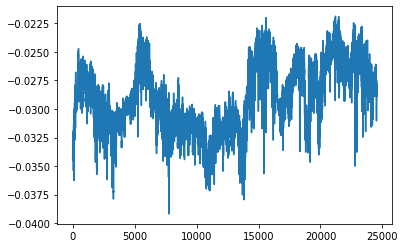

In [89]:
plt.plot(preds)

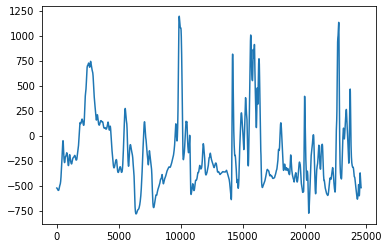

In [90]:
plt.plot(val.y)